In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/AAMAS_output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


In [3]:
pd.__version__

'1.1.0'

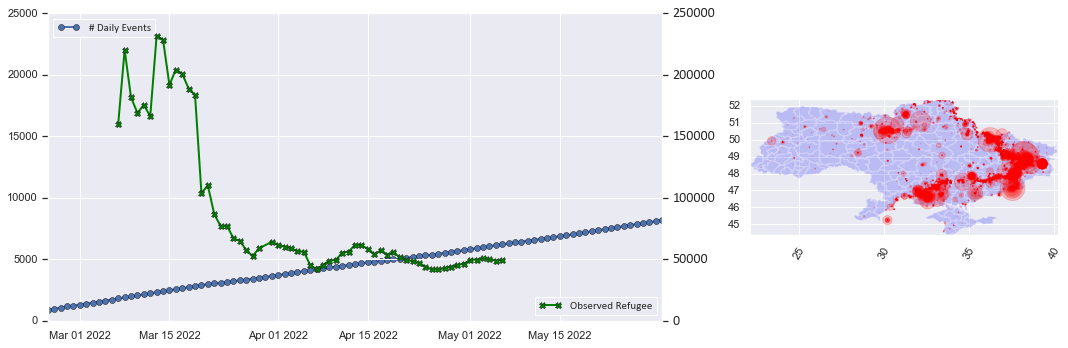

In [4]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [5]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [6]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            #print(cur_id,'not found')
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_results_for_state(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,IDP_REFUGEE_PROB=0.1,partition = 40,scale_1 = 0.5,scale_2 = 2):
    OUTPUT_DIR_OLD = BASE_DIR+'output_data/' 
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR_OLD+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR_OLD+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR_OLD+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    
    #adjustment
    BORDER_CROSS_PROB = float(np.random.normal(0.32,0.02,1)[0])
    IDP_PROB = 1.0 - BORDER_CROSS_PROB
    #IDP_REFUGEE_PROB = 0.1
    ovr_df['FD'] = ovr_df['refugee']/BORDER_CROSS_PROB
    ovr_df['IDP'] = ovr_df['FD']*IDP_PROB
    
    f_list = ovr_df['FD'].tolist()
    r_list = ovr_df['refugee'].tolist()
    i_list = ovr_df['IDP'].tolist()
    
    for i in range(1,len(f_list)):
        i_list[i] = f_list[i]*IDP_PROB + i_list[i-1]*(1-IDP_REFUGEE_PROB)
    for i in range(1,len(f_list)):
        r_list[i] = f_list[i]*BORDER_CROSS_PROB + i_list[i-1]*(IDP_REFUGEE_PROB)
    
    ovr_df['refugee'] = r_list
    
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [7]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [8]:
r1 = list(get_raion_list(20000,prefix='mim_result'))
print(len(r1))

120


In [9]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3


In [11]:
import json

samples = []
with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -40000

for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        good.append(i)
print(good)

[18, 19, 20, 21]


In [12]:
# rmse_1 = []
# rmse_2 = []



# for i in range(0,len(good)):
#     res = get_results_for_2(5000+good[i],prefix='mim_result',partition=20,scale_1=1.0,scale_2=1.0)
#     comp_df = res.merge(refugee_data,on='time',how='inner')
#     comp_df['diff'] = (comp_df['refugee_y']-comp_df['refugee_x'])**2
#     rmse = ((comp_df[5:10]['diff'].sum()+comp_df[50:55]['diff'].sum())/10)**0.5 #10 data points
#     rmse_full = ((comp_df['diff'].sum())/comp_df.shape[0])**0.5 #10 data points
#     rmse_1.append(rmse)
#     rmse_2.append(rmse_full)
#     print(good[i],rmse,rmse_full)
#     #ax.plot(rmse,rmse)


In [13]:
# import warnings
# warnings.filterwarnings('ignore')

# #simulation_indices = [100,110,111,112,113,114]
# #simulation_indices = [115,116,117,118,119]
# #simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
# #simulation_indices = [1001,1002,1004,1009]
# #simulation_indices = [100,101,102,105]
# simulation_indices = [i for i in range(20000,20000+100)]
# #first_df = []
# incomplete_df = []

# for vv in simulation_indices:
#     try:
#         print(vv,end=' ')
#         current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=40,scale_1=1.0*1.2,scale_2=2.0*1.4)
#         current_df['comb'] = str(vv)
#         #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#         #current_df_unsmoothed['comb'] = str(vv)
#         incomplete_df.append(current_df)
#     except:
#         continue

# incomplete_df = pd.concat(incomplete_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [14]:
import warnings
warnings.filterwarnings('ignore')

#simulation_indices = [100,110,111,112,113,114]
#simulation_indices = [115,116,117,118,119]
#simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
#simulation_indices = [1001,1002,1004,1009]
#simulation_indices = [100,101,102,105]
simulation_indices = [i for i in range(20000,20000+100)]
first_df = []
second_df = []

for vv in simulation_indices:
    try:
        print(vv,end=' ')
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.0*1.2,scale_2=2.0*1.4)
        current_df['comb'] = str(vv)
        #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
        #current_df_unsmoothed['comb'] = str(vv)
        first_df.append(current_df)
    except:
        continue

first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

20000 120 raions found
20001 121 raions found
20002 120 raions found
20003 120 raions found
20004 120 raions found
20005 120 raions found
20006 120 raions found
20007 120 raions found
20008 120 raions found
20009 120 raions found
20010 121 raions found
20011 121 raions found
20012 120 raions found
20013 120 raions found
20014 121 raions found
20015 120 raions found
20016 120 raions found
20017 120 raions found
20018 120 raions found
20019 120 raions found
20020 121 raions found
20021 121 raions found
20022 120 raions found
20023 121 raions found
20024 120 raions found
20025 120 raions found
20026 120 raions found
20027 121 raions found
20028 121 raions found
20029 121 raions found
20030 120 raions found
20031 119 raions found
20032 120 raions found
20033 120 raions found
20034 120 raions found
20035 120 raions found
20036 120 raions found
20037 120 raions found
20038 120 raions found
20039 121 raions found
20040 121 raions found
20041 121 raions found
20042 121 raions found
20043 120 r

In [15]:

simulation_indices_state = [80000+i for i in range(9,18)]
first_df_state = []
#second_df = []

for vv in simulation_indices_state:
    print(vv,end=' ')
    current_df = get_results_for_state(vv,prefix='mim_result',ROLL=7,IDP_REFUGEE_PROB=0.2,partition=40,scale_1=0.7,scale_2=0.5)
    current_df['comb'] = str(vv)
    #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
    #current_df_unsmoothed['comb'] = str(vv)

    first_df_state.append(current_df)
    #second_df.append(current_df_unsmoothed)
first_df_state = pd.concat(first_df_state).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

80009 137 raions found
80010 136 raions found
80011 137 raions found
80012 136 raions found
80013 132 raions found
80014 132 raions found
80015 136 raions found
80016 137 raions found
80017 137 raions found


In [16]:
# import warnings
# warnings.filterwarnings('ignore')

# #simulation_indices = [100,110,111,112,113,114]
# #simulation_indices = [115,116,117,118,119]
# #simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
# #simulation_indices = [1001,1002,1004,1009]
# #simulation_indices = [100,101,102,105]
# simulation_indices = [i for i in range(20000,20000+100)]
# first_df = []
# second_df = []

# for vv in simulation_indices:
#     try:
#         print(vv,end=' ')
#         current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.0*1.2,scale_2=2.0*1.4)
#         current_df['comb'] = str(vv)
#         #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#         #current_df_unsmoothed['comb'] = str(vv)
#         first_df.append(current_df)
#     except:
#         continue

# first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [17]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
#refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
#refugee_data_2.at[71, 'refugee'] = 49355.571429

refugee_data_2

,time,cumulative,daily,refugee
6,2022-03-02,989560,170799,141365.714286
7,2022-03-03,1173690,184130,156354.428571
8,2022-03-04,1343790,170100,166323.571429
9,2022-03-05,1540463,196673,173957.571429
10,2022-03-06,1742987,202524,178936.285714
...,...,...,...,...
90,2022-05-25,6652164,48379,46706.285714
91,2022-05-26,6700411,48247,46780.428571
92,2022-05-27,6737208,36797,44601.142857
93,2022-05-28,6771963,34755,42605.428571


In [18]:
first_df

comb,time,20000,20001,20002,20003,20004,20005,20006,20007,20008,...,20090,20091,20092,20093,20094,20095,20096,20097,20098,20099
0,2022-03-02,149331.257143,144427.885714,158122.114286,170300.914286,2.641546e+05,27462.514286,169358.057143,282086.571429,562248.000000,...,146396.228571,4.436049e+05,3.397354e+04,1.509783e+05,82575.942857,153526.971429,244866.857143,127819.200000,221592.685714,70645.542857
1,2022-03-03,183620.742857,141194.914286,184268.400000,182072.400000,2.762038e+05,41587.028571,217781.142857,356013.428571,569841.257143,...,169222.971429,4.248835e+05,4.744457e+04,2.081122e+05,97488.685714,159971.314286,266369.142857,151894.285714,249703.885714,90760.114286
2,2022-03-04,241566.342857,161218.628571,211875.600000,190898.228571,3.235277e+05,61019.485714,274095.257143,430198.285714,573397.714286,...,202660.800000,3.454819e+05,6.944726e+04,2.431755e+05,107725.885714,183829.885714,333670.628571,165614.742857,281833.028571,132751.200000
3,2022-03-05,296755.714286,167984.571429,234611.142857,182661.771429,3.288747e+05,83340.857143,323892.514286,500499.600000,532811.828571,...,233674.114286,3.175035e+05,8.422269e+04,2.760189e+05,124446.000000,190541.485714,373123.028571,193507.371429,363042.514286,177635.657143
4,2022-03-06,328693.885714,175195.885714,236880.857143,145023.942857,2.843750e+05,92810.571429,363888.685714,528848.914286,450519.600000,...,266058.171429,2.954234e+05,9.865251e+04,2.997909e+05,133603.714286,176708.914286,375470.057143,226245.257143,393045.942857,218508.171429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2022-09-16,0.000000,2.000000,0.000000,0.000000,7.042088e-11,2.000000,0.000000,0.000000,0.000000,...,0.000000,2.702499e-11,4.722876e-11,3.326152e-11,0.000000,4.800000,0.000000,0.000000,0.000000,0.000000
199,2022-09-17,0.000000,2.000000,0.000000,0.000000,7.042088e-11,2.000000,0.000000,0.000000,0.000000,...,0.000000,2.702499e-11,4.722876e-11,2.400000e+00,2.400000,6.800000,0.000000,0.000000,0.000000,0.000000
200,2022-09-18,0.000000,2.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.000000,0.000000,...,0.000000,2.702499e-11,0.000000e+00,2.400000e+00,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000
201,2022-09-19,0.000000,2.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.702499e-11,0.000000e+00,2.400000e+00,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# refugee_data_full = pd.read_csv('ukr_refugee_full.csv')
# refugee_data_full['refugee'] = refugee_data_full['Cumulative Refugees'].diff()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# refugee_data_full['time'] = pd.to_datetime(refugee_data_full['Date'])
# refugee_data_full = refugee_data_full.sort_values(by='time')
# refugee_data_full['refugee'] = refugee_data_full['refugee'].rolling(ROLLING).mean()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# refugee_data_full
# refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
# refugee_data_2 = refugee_data_2.sort_values(by='time')
# refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
# refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# # refugee_data['refugee'] = refugee_data['refugee'].diff()
# # refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data_2

## Do specifying different cores and memory change result apart from stochasticity?

In [20]:
refugee_data['refugee'].std()

58806.59301512547

In [21]:
refugee_data['refugee'].mean()

86002.91904761906

In [22]:
refugee_data['refugee'].sum()

5160175.142857144

In [23]:
refugee_data_2['refugee'].sum()
refugee_data_2['refugee'].mean()

71078.05136436597

[19059. 19080. 19101. 19122.]


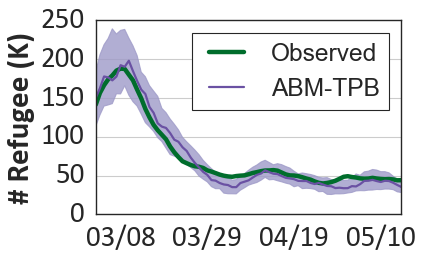

In [25]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.35,q3=0.65)
median_normal_state,q1_normal_state,q3_normal_state = get_uncertainty(simulation_indices_state,first_df_state,q1=0.35,q3=0.65)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(6,4))
#plt.xticks(rotation=25)

#ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed',linewidth=4,color='#006d2c')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices):
    #print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        #ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8)
    except Exception as e:
        #print(e)
        continue
sns.set_style('white')
SHIFT = -1
ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM-TPB')
ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.8)
#ax.plot(first_df_state['time'],median_normal_state/1000,linewidth=2,color='#b35806',alpha=1,label='Pandey et al.')
#ax.fill_between(first_df_state['time'], q1_normal_state/1000, q3_normal_state/1000, color='#e08214',alpha=0.5)
#ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='red',alpha=0.1,label='ABM')
#ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='red',alpha=0.1)

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
#sns.set_style('whitegrid')
#ax.annotate('RMSPE = 0.23', xy=(19100, 120),fontsize=20,fontweight='bold')
#ax.annotate('PCC = 0.98', xy=(19100, 100),fontsize=20,fontweight='bold')
ax.legend(loc='best',ncol=1,fontsize=22)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 2), datetime.date(2022, 5, 15)])
#ax.set_ylim([0,300])
ax.grid(axis='y')
print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/aamas_abm_result.png',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

20000 20001 20002 20003 20004 20005 20006 20007 20008 20009 20010 20011 20012 20013 20014 20015 20016 20017 20018 20019 20020 20021 20022 20023 20024 20025 20026 20027 20028 20029 20030 20031 20032 20033 20034 20035 20036 20037 20038 20039 20040 20041 20042 20043 20044 20045 20046 20047 20048 20049 20050 20051 20052 20053 20054 20055 20056 20057 20058 20059 20060 20061 20062 20063 20064 20065 20066 20067 20068 20069 20070 20071 20072 20073 20074 20075 20076 20077 20078 20079 20080 20081 20082 20083 20084 20085 20086 20087 20088 20089 20090 20091 20092 20093 20094 20095 20096 20097 20098 20099 

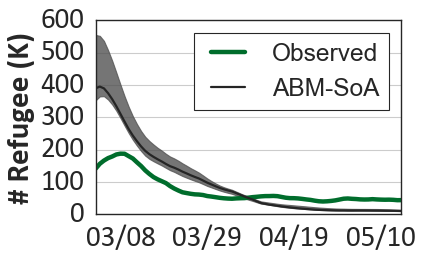

In [26]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.35,q3=0.65)
median_normal_state,q1_normal_state,q3_normal_state = get_uncertainty(simulation_indices_state,first_df_state,q1=0.35,q3=0.65)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(6,4))
#plt.xticks(rotation=15)

#ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed',linewidth=4,color='#006d2c')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices):
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        #ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8)
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
SHIFT = -1
#ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM-Agency',marker='x')
#ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.8)
ax.plot(first_df_state['time'],median_normal_state/1000,linewidth=2,color='#252525',alpha=1,label='ABM-SoA')
ax.fill_between(first_df_state['time'], q1_normal_state/1000, q3_normal_state/1000, color='#525252',alpha=0.8)
#ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='red',alpha=0.1,label='ABM')
#ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='red',alpha=0.1)

myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.xaxis.set_major_formatter(myFmt)
#ax.annotate('RMSPE = 0.77', xy=(19100, 200),fontsize=20,fontweight='bold')
#ax.annotate('PCC = 0.94', xy=(19100, 150),fontsize=20,fontweight='bold')
#ax.set_facecolor("white")
#sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=22)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 2), datetime.date(2022, 5, 15)])
#ax.set_ylim([0,300])
ax.grid(axis='y')
#print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/aamas_sofa_result.png',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [27]:
top_20_indices = [20089, 20042, 20074, 20058, 20037, 20025, 20095, 20059, 20063, 20082, 20048, 20013, 20019, 20026, 20070, 20012, 20072, 20016, 20071, 20099]

In [28]:
first_df['median'] = median_normal.shift(SHIFT)
first_df['q1'] = q1_normal.shift(SHIFT)
first_df['q3'] = q3_normal.shift(SHIFT)
first_df = first_df[0:SHIFT]


In [29]:
first_df['median_state'] = median_normal_state[0:first_df.shape[0]]
first_df['q1_state'] = q1_normal_state[0:first_df.shape[0]]
first_df['q3_state'] = q3_normal_state[0:first_df.shape[0]]

compare_df = first_df.merge(refugee_data_2,on='time',how='inner')

In [30]:
compare_df = first_df.merge(refugee_data_2,on='time',how='inner')
compare_df

,time,20000,20001,20002,20003,20004,20005,20006,20007,20008,...,20099,median,q1,q3,median_state,q1_state,q3_state,cumulative,daily,refugee
0,2022-03-02,149331.257143,144427.885714,158122.114286,170300.914286,264154.628571,27462.514286,169358.057143,282086.571429,562248.000000,...,70645.542857,150189.257143,113604.660000,183847.422857,389859.880055,352750.785535,554732.955774,989560,170799,141365.714286
1,2022-03-03,183620.742857,141194.914286,184268.400000,182072.400000,276203.828571,41587.028571,217781.142857,356013.428571,569841.257143,...,90760.114286,162445.800000,127967.888571,205463.100000,395082.613800,364722.550153,551964.310922,1173690,184130,156354.428571
2,2022-03-04,241566.342857,161218.628571,211875.600000,190898.228571,323527.714286,61019.485714,274095.257143,430198.285714,573397.714286,...,132751.200000,177646.971429,139504.671429,218594.031429,389591.352762,365457.407109,536478.946881,1343790,170100,166323.571429
3,2022-03-05,296755.714286,167984.571429,234611.142857,182661.771429,328874.742857,83340.857143,323892.514286,500499.600000,532811.828571,...,177635.657143,176482.371429,140963.657143,226688.837143,374718.261104,355100.404957,507820.003045,1540463,196673,173957.571429
4,2022-03-06,328693.885714,175195.885714,236880.857143,145023.942857,284374.971429,92810.571429,363888.685714,528848.914286,450519.600000,...,218508.171429,172639.457143,142654.285714,239028.685714,356116.489681,339739.232003,475079.366265,1742987,202524,178936.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2022-05-25,19932.400000,17915.200000,52120.800000,22282.400000,36119.600000,19058.400000,34169.200000,11659.200000,23696.000000,...,18589.600000,20795.200000,15830.880000,30410.860000,8668.538539,8386.913672,10918.435024,6652164,48379,46706.285714
85,2022-05-26,19385.600000,11956.000000,51800.400000,23708.400000,36754.400000,14900.000000,35371.600000,12120.000000,22534.400000,...,19931.200000,20597.000000,16324.660000,29852.960000,8937.101349,8614.230392,11362.254672,6700411,48247,46780.428571
86,2022-05-27,18538.400000,11112.800000,49637.600000,25185.200000,37922.000000,13808.400000,36778.800000,10808.800000,23688.800000,...,20294.800000,19718.400000,16369.500000,29627.620000,9290.505136,9037.618804,12022.833719,6737208,36797,44601.142857
87,2022-05-28,18613.200000,12468.400000,49032.000000,26859.200000,36410.000000,17816.000000,33552.800000,13064.000000,24371.200000,...,19288.400000,20299.000000,16548.940000,28712.060000,9826.942170,9263.701130,12594.716201,6771963,34755,42605.428571


In [31]:
# compare_df = first_df.merge(refugee_data_2,on='time',how='inner')
# compare_df

In [32]:
# compare_df['median'] = compare_df['median'].shift(-2)
# compare_df['q1'] = compare_df['q1'].shift(-2)
# compare_df['q3'] = compare_df['median'].shift(-2)
# for pp in simulation_indices:
#     compare_df[str(pp)] = compare_df[str(pp)].shift(-2)
# compare_df = compare_df.dropna(subset=['median'])

In [33]:
pcc = compare_df['median'].corr(compare_df['refugee'])
print(pcc)
rmspe = ((((compare_df['median'] - compare_df['refugee'])/compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(rmspe)
rmse = ((((compare_df['median'] - compare_df['refugee'])/1)**2).sum()/compare_df.shape[0])**0.5
print(rmse)
mape = (abs((compare_df['median']-compare_df['refugee'])/compare_df['refugee'])).sum()/compare_df.shape[0]
print(mape)

0.9815663646970235
0.23627916847055977
12443.794988561174
0.17878437670805025


In [84]:
mase_nom = (abs(compare_df['median'] - compare_df['refugee'])).sum()/compare_df.shape[0]
mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
print(mase_nom,mase_denom)
mase = mase_nom/mase_denom
print(mase)

7992.437333333326 3092.266409266409
2.5846535438805884


In [34]:
pcc = compare_df['median_state'].corr(compare_df['refugee'])
print(pcc)
rmspe = ((((compare_df['median_state'] - compare_df['refugee'])/compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(rmspe)
rmse = ((((compare_df['median_state'] - compare_df['refugee'])/1)**2).sum()/compare_df.shape[0])**0.5
print(rmse)
mape = (abs((compare_df['median_state']-compare_df['refugee'])/compare_df['refugee'])).sum()/compare_df.shape[0]
print(mape)

0.939186629920514
0.7273353730303832
68781.25334457801
0.682478830677688


In [51]:
mase_nom = (abs(compare_df['median_state'] - compare_df['refugee'])).sum()/compare_df.shape[0]
mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
print(mase_nom,mase_denom)
mase = mase_nom/mase_denom
print(mase)

51934.01738929768 2726.1233766233763
19.050501468361293


In [53]:
# mase_nom = (abs(compare_df['median'] - compare_df['refugee'])).sum()/compare_df.shape[0]
# mase_denom = (abs(compare_df['refugee'].diff().dropna()).sum())/(compare_df.shape[0]-1)
# mase = mase_nom/mase_denom
# print(mase)

In [57]:
new_compare_df = compare_df.copy()

In [58]:
compare_df = compare_df[0:75]

In [59]:
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum())
# compare_df['q1'].sum()
# compare_df['q3'].sum()

3736015.028571428
3002767.9199999995
4571523.3599999985
3511470.714285714
1296584.0285714285
1477772.4285714284
1037485.2628571421
1625958.5714285716


In [60]:
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median_state'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1_state'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3_state'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median_state'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1_state'].sum())
print(compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3_state'].sum())
# compare_df['q1'].sum()
# compare_df['q3'].sum()

6454146.399999629
5798364.306760945
7802580.638462929
3511470.714285714
1046952.8875581138
1477772.4285714284
937482.1833639366
1192573.7549234533


In [61]:
print(compare_df['refugee'].sum())
print(compare_df['median'].sum())
print(compare_df['median_state'].sum())

5683899.285714286
5627042.657142855
7690235.356196688


In [62]:
print(compare_df['q1_state'].sum())
print(compare_df['q3_state'].sum())
print(compare_df['q1'].sum())
print(compare_df['q3'].sum())

6892274.996693984
9235468.150326878
4494998.462857142
6957587.231428572


In [63]:
x = 6892274
y = 5798364
z = 937482
a = 9235468
b = 7802580
c = 1192573

In [66]:
x_axis = ['Overall','March','April']
Method = ['Observed','ABM','Pandey']
colors = ['#006d2c','#6a51a3','#252525']
#values = [[overall,march,april]for method 1,...]
values = [[5683899,3511470,1477772],[5627042,3736015,1296584],[7690235,6454146,1046952]]
errmin = [[0,0,0],[values[1][0]-4494998,values[1][1]-3002767,values[1][2]-1037485],[values[2][0]-x,values[2][1]-y,values[2][2]-z]]
errmax = [[0,0,0],[6957587-values[1][0],4571523-values[1][1],1625958-values[1][2]],[a-values[2][0],b-values[2][1],c-values[2][2]]]

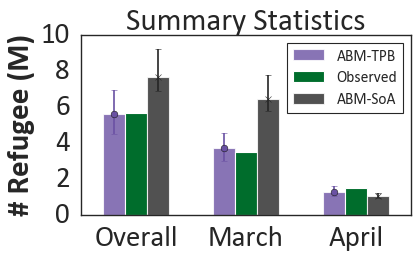

In [81]:
# Numbers of pairs of bars you want

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

N = len(x_axis)

truth_bar = values[0]
abm_bar = values[1]
pandey_bar = values[2]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig,ax = plt.subplots(figsize=(6,4))

# Width of a bar 
width = 0.2       

# Plotting
ax.bar(ind - width, np.array(abm_bar)/1e6 , width, label='ABM-TPB',color=colors[1],alpha=0.8)
ax.errorbar(ind - width, np.array(abm_bar)/1e6, yerr = [np.array(errmin[1])/1e6,np.array(errmax[1])/1e6],fmt='o',color=colors[1])

ax.bar(ind, np.array(truth_bar)/1e6 , width, label='Observed',color=colors[0])

ax.bar(ind + width, np.array(pandey_bar)/1e6 , width, label='ABM-SoA',color=colors[2],alpha=0.8)
ax.errorbar(ind + width, np.array(pandey_bar)/1e6, yerr = [np.array(errmin[2])/1e6,np.array(errmax[2])/1e6],fmt='x',color=colors[2])

ax.set_ylabel('# Refugee (M)',fontweight='bold')

ax.set_title('Summary Statistics')

ax.set_xticks(ind)
ax.set_xticklabels(x_axis)
#ax.set_yticks
# Finding the best position for legends and putting it
ax.legend(loc='best',fontsize=14,ncol=1)
ax.set_ylim([0,10])
fig.tight_layout()
fig.savefig('../Figures/summary_stat.png',dpi=350,bbox_inches='tight')

In [40]:
# print(metric_df.sort_values(by=['mse']).head(20)['run_idx'].astype(int).tolist())

## Analyze results from LHS

### first gather all the parameter space covered by LHS

In [41]:
def get_params_from_file(filename):
    with open(filename,'r') as f:
        line = f.readlines()[0]
        args = line.split()
        #print(args)
        param_dict = {'D':float(args[6]),'A':float(args[7]),'T':float(args[8]),'S':float(args[9]),'t_r':int(args[10]),'beta_1':float(args[12]),'beta_2':float(args[13]),
                      'pi_lo':float(args[15]),'pi_hi':float(args[16]),'lambda_1':float(args[17]),'lambda_2':1-float(args[17]),'b_prob':float(args[20]),'p_iter':int(args[25])}
    f.close()
    return param_dict


all_params = []

for i in range(20000,20100):
    filename = "LHS_SAMPLE_"+str(i)+".sh"
    param_dict = get_params_from_file(filename)
    param_dict['hyper_comb'] = i
    all_params.append(param_dict)
    
lhs_param_df = pd.DataFrame.from_dict(all_params)
lhs_param_df

,D,A,T,S,t_r,beta_1,beta_2,pi_lo,pi_hi,lambda_1,lambda_2,b_prob,p_iter,hyper_comb
0,2.831176,45.411820,2.422179,46.541909,3,0.686638,0.289037,0.094940,0.490262,0.740918,0.259082,0.335076,2,20000
1,4.435379,33.604361,2.634121,73.349321,8,0.905011,0.784056,0.066045,0.882867,0.589244,0.410756,0.331213,3,20001
2,4.764692,69.648080,1.007723,9.495490,3,0.782222,0.220737,0.027456,0.838665,0.710443,0.289557,0.356115,2,20002
3,4.187796,48.987643,1.695427,13.706125,3,0.185530,0.166866,0.098938,0.651743,0.453513,0.546487,0.250919,4,20003
4,1.302256,66.268281,2.977944,4.568763,6,0.514779,0.077862,0.075313,0.542286,0.088325,0.911675,0.396552,4,20004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.071038,52.681946,2.340896,35.576832,6,0.918551,0.592917,0.055133,0.710004,0.776974,0.223026,0.308212,4,20095
96,1.446312,51.467685,2.808122,26.582585,3,0.874078,0.055457,0.071429,0.981925,0.480247,0.519753,0.399639,3,20096
97,1.607279,65.146913,2.319547,5.118949,9,0.482696,0.487503,0.062982,0.483367,0.095907,0.904093,0.389809,1,20097
98,3.039288,45.078870,1.892342,54.889223,4,0.968533,0.353620,0.053599,0.964687,0.909797,0.090203,0.391651,3,20098


In [42]:
def get_params_from_file(filename):
    with open(filename,'r') as f:
        line = f.readlines()[0]
        args = line.split()
        #print(args)
        param_dict = {'D':float(args[6]),'A':float(args[7]),'T':float(args[8]),'S':float(args[9]),'t_r':int(args[10]),'beta_1':float(args[12]),'beta_2':float(args[13]),
                      'pi_lo':float(args[15]),'pi_hi':float(args[16]),'lambda_1':float(args[17]),'lambda_2':1-float(args[17]),'b_prob':float(args[20]),'p_iter':int(args[25])}
    f.close()
    return param_dict

print(get_params_from_file('LHS_SAMPLE_20074.sh'))
print(get_params_from_file('LHS_SAMPLE_20042.sh'))
print(get_params_from_file('LHS_SAMPLE_20089.sh'))

{'D': 2.18663941021782, 'A': 37.060756808501864, 'T': 1.0348449500885029, 'S': 57.91356700688765, 't_r': 6, 'beta_1': 0.1781240295913104, 'beta_2': 0.8762308137940877, 'pi_lo': 0.09264433888912414, 'pi_hi': 0.6674105660199474, 'lambda_1': 0.4980495151203558, 'lambda_2': 0.5019504848796442, 'b_prob': 0.32547145503549796, 'p_iter': 4}
{'D': 3.873008070488465, 'A': 43.19473040158702, 'T': 2.835951249156568, 'S': 15.2320047494748, 't_r': 8, 'beta_1': 0.13543593439692808, 'beta_2': 0.8106345404649975, 'pi_lo': 0.02561506076832155, 'pi_hi': 0.4479652516707181, 'lambda_1': 0.14745980455382662, 'lambda_2': 0.8525401954461733, 'b_prob': 0.2567658397968005, 'p_iter': 3}
{'D': 4.013392668224993, 'A': 35.54586082550363, 'T': 2.8572254156167416, 'S': 31.813902706057913, 't_r': 4, 'beta_1': 0.6724382292457873, 'beta_2': 0.8574135208163113, 'pi_lo': 0.017421250888280622, 'pi_hi': 0.9899915466653364, 'lambda_1': 0.36774379606348145, 'lambda_2': 0.6322562039365185, 'b_prob': 0.2405191926581789, 'p_iter

### gather outputs of interest for each parameter space
### outputs of interest: total migration, migration in march, migration in april, migration in may, max migration one day

In [43]:
all_outputs = []

for pp in simulation_indices:
    
    tot_migration = compare_df[str(pp)].sum()
    march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))][str(pp)].sum()
    april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))][str(pp)].sum()
    may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))][str(pp)].sum()
    max_migration = compare_df[str(pp)].max()
    
    ob_tot_migration = compare_df['refugee'].sum()
    ob_march_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
    ob_april_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
    ob_may_migration = compare_df[(compare_df.time>=pd.to_datetime('2022-05-01')) & (compare_df.time<=pd.to_datetime('2022-05-31'))]['refugee'].sum()
    ob_max_migration = compare_df[str(pp)].max()
    
    output_dict = {'hyper_comb':pp,'output_tot':tot_migration,'output_MAR':march_migration,'output_APR':april_migration,'output_MAY':may_migration,'output_MAX':max_migration,
                  'obs_tot':ob_tot_migration,'obs_MAR':ob_march_migration,'obs_APR':ob_april_migration,'obs_MAY':ob_may_migration,'obs_MAX':ob_max_migration}
    all_outputs.append(output_dict)
    
output_df = pd.DataFrame.from_dict(all_outputs)
#output_df

## merge the two dataframes for sensitivity analysis

In [44]:
output_vs_param_df = lhs_param_df.merge(output_df,on='hyper_comb',how='inner')
#output_vs_param_df

In [49]:
param_names = lhs_param_df.columns.tolist()[0:-1]
param_names.remove('t_r')
param_names.remove('lambda_2')
param_names.remove('beta_2')
param_names.remove('b_prob')
param_names.remove('p_iter')

outputs_of_interest = output_df.columns.tolist()[1:6]
outputs_observed = output_df.columns.tolist()[6:11]
outputs_of_interest.remove('output_MAY')
outputs_observed.remove('obs_MAY')

In [50]:
input_mapping = {'D':'$\\delta$','A':'Q','S':'$\\theta$','T':'$\\tau$','t_r':'$\\alpha$','beta_1':'$\\beta$','beta_2':'$\\beta2$',
                 'pi_lo':'$\\pi^{\\downarrow}$','pi_hi':'$\\pi$','lambda_1':'$\\lambda$','lambda_2':'$\\alpha$','p_iter':'Hop','b_prob':'$\\alpha$'}

In [51]:
#print(r'$\alpha_i > \beta_i$')

## create scatter plot for each output of interest and each single parameter

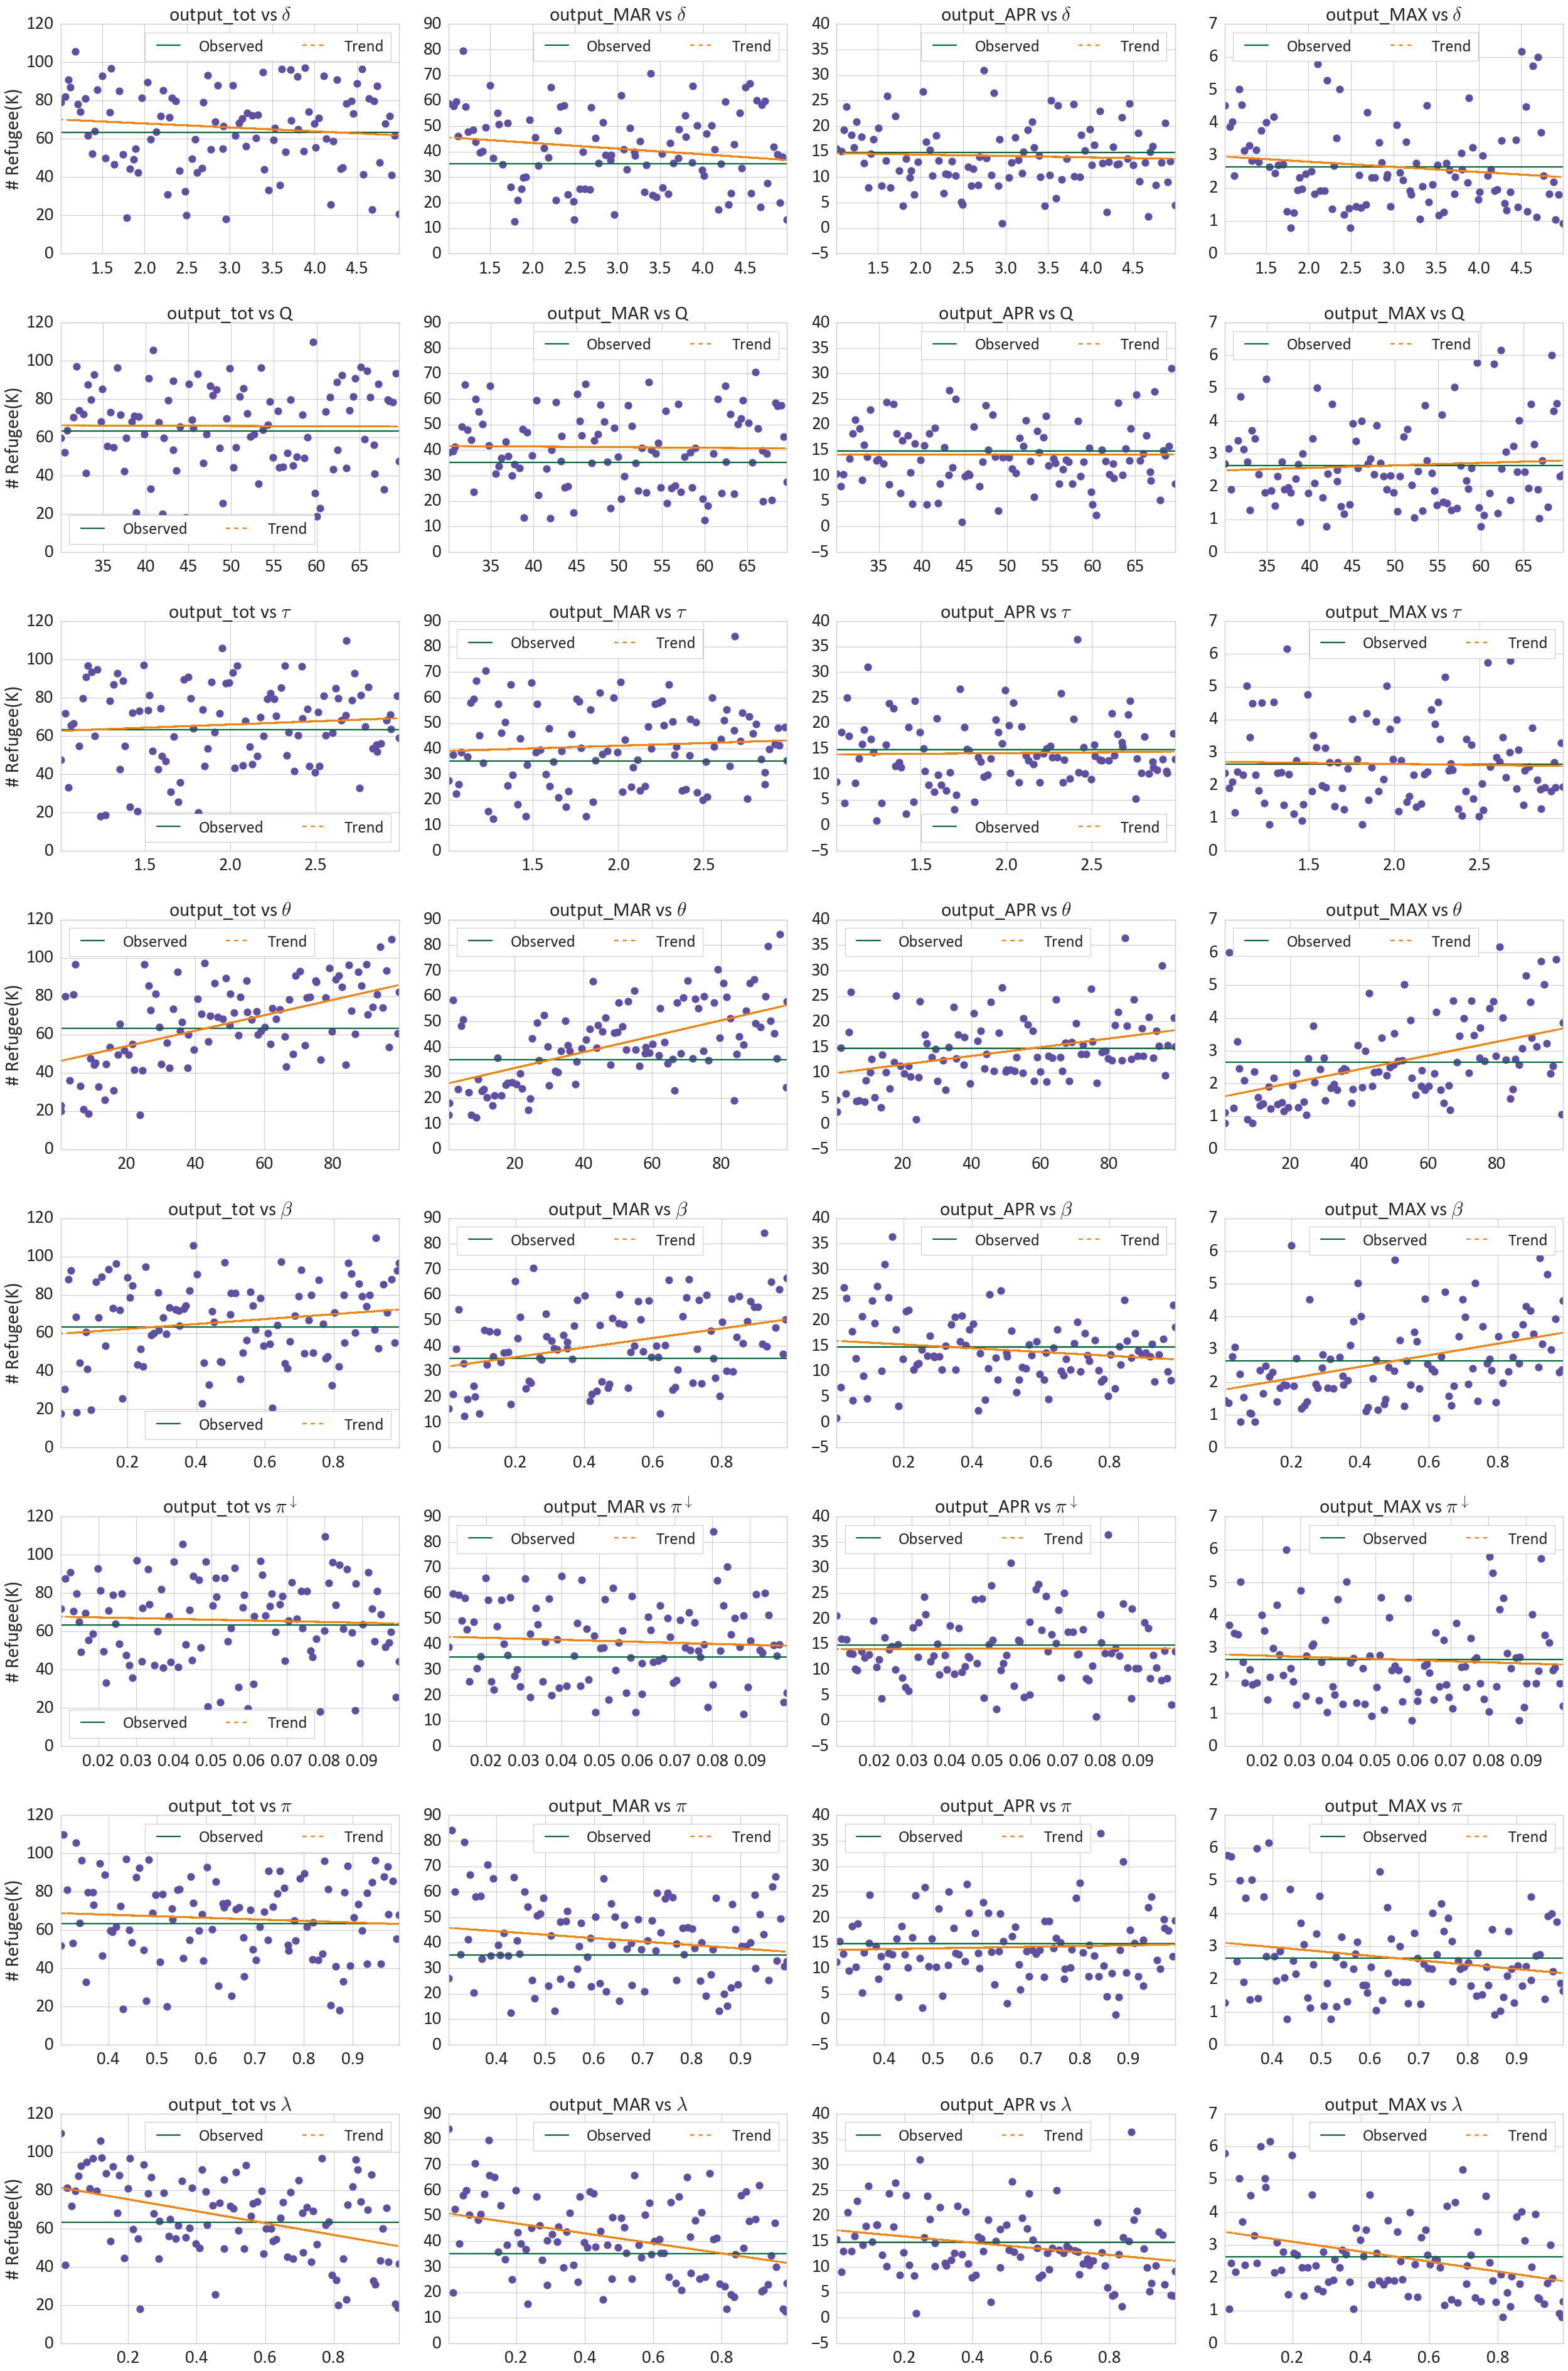

In [52]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(len(param_names),len(outputs_of_interest),figsize=(8*len(outputs_of_interest),6*len(param_names)))

for i,param in enumerate(param_names):
    for j,out in enumerate(outputs_of_interest):
        ax[i][j].scatter(output_vs_param_df[param],output_vs_param_df[out]/100000,s=100,color='#5e4fa2')
        ax[i][j].set_title(out+' vs '+input_mapping[param],fontsize=28)
        
        ax[i][j].axhline(y=output_vs_param_df[outputs_observed[j]].mean()/100000,color='#006837',label='Observed',linewidth=2)
        ax[i][j].set_xlim([output_vs_param_df[param].min(),output_vs_param_df[param].max()])
        if(j==0):
            ax[i][j].set_ylabel('# Refugee(K)')
        z = np.polyfit(output_vs_param_df[param],output_vs_param_df[out]/100000,1)
        p = np.poly1d(z)
        ax[i][j].plot(output_vs_param_df[param],p(output_vs_param_df[param]),"r--",label='Trend',color='#ff7f00',linewidth=2)
        ax[i][j].legend(loc='best',fontsize=24,ncol=2)
fig.tight_layout()

In [53]:
import pingouin as pg

prcc_dict_pearson = []
prcc_dict_spearman = []

for output in outputs_of_interest:
    for param in param_names:
        covs = [p for p in param_names if p!=param]
        #print(param,output)
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs).round(20)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Pearson',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        
        new_row_pearson = {'Param':input_mapping[param],'Output':output,'PRCC':cur_df_pearson['r'].mean(),'CI95%':cur_df_pearson['CI95%'].mean(),'p-value':cur_df_pearson['p-val'].mean()}
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs,method='spearman').round(7)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Spearman',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
            
        new_row_spearman = {'Param':input_mapping[param],'Output':output,'PRCC':cur_df_pearson['r'].mean(),'CI95%':cur_df_pearson['CI95%'].mean(),'p-value':cur_df_pearson['p-val'].mean()}
        #print('')
        prcc_dict_pearson.append(new_row_pearson)
        prcc_dict_spearman.append(new_row_spearman)
        
prcc_df_pearson = pd.DataFrame.from_dict(prcc_dict_pearson)
prcc_df_spearman = pd.DataFrame.from_dict(prcc_dict_spearman)

In [54]:
param_names

['D', 'A', 'T', 'S', 'beta_1', 'pi_lo', 'pi_hi', 'lambda_1']

In [55]:
pearson_by_output_type = [x for _, x in prcc_df_pearson.groupby('Output')]
pearson_by_ = [y for y, x in prcc_df_pearson.groupby('Output')]

for i in range(0,len(pearson_by_output_type)):
    all_cols = pearson_by_output_type[i].columns.tolist()
    for col in all_cols:
        #print(col)
        if col=='Param':
            continue
        if col=='Output':
            continue
        #print(col)
        pearson_by_output_type[i] = pearson_by_output_type[i].rename(columns={col:col+' for '+pearson_by_[i]})
    print('')
    pearson_by_output_type[i] = pearson_by_output_type[i].drop(columns=['Output'])

rearranged_df = pearson_by_output_type[0]

for df in pearson_by_output_type[1:]:
    rearranged_df = rearranged_df.merge(df,on='Param',how='inner')

coloring_columns = [c for c in rearranged_df.columns.tolist() if c.startswith('p-value')]
print(coloring_columns)
rearranged_df = rearranged_df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=coloring_columns)
rearranged_df





['p-value for output_APR', 'p-value for output_MAR', 'p-value for output_MAX', 'p-value for output_tot']


,Param,PRCC for output_APR,CI95% for output_APR,p-value for output_APR,PRCC for output_MAR,CI95% for output_MAR,p-value for output_MAR,PRCC for output_MAX,CI95% for output_MAX,p-value for output_MAX,PRCC for output_tot,CI95% for output_tot,p-value for output_tot
0,$\delta$,-0.051793,[-0.25 0.15],0.621977,-0.241123,[-0.42 -0.04],0.019895,-0.232075,[-0.42 -0.03],0.025193,-0.138975,[-0.33 0.07],0.183994
1,Q,-0.006414,[-0.21 0.2 ],0.951347,-0.023605,[-0.23 0.18],0.822296,0.106000,[-0.1 0.3],0.311894,-0.018164,[-0.22 0.19],0.862800
2,$\tau$,-0.002785,[-0.21 0.2 ],0.978860,0.029677,[-0.18 0.23],0.777646,-0.136368,[-0.33 0.07],0.192440,0.055282,[-0.15 0.26],0.598671
3,$\theta$,0.392301,[0.2 0.55],0.000101,0.636915,[0.5 0.74],0.000000,0.563303,[0.41 0.69],0.000000,0.564579,[0.41 0.69],0.000000
4,$\beta$,-0.184539,[-0.37 0.02],0.076593,0.513651,[0.35 0.65],0.000000,0.550653,[0.39 0.68],0.000000,0.266620,[0.07 0.45],0.009784
5,$\pi^{\downarrow}$,-0.052920,[-0.25 0.15],0.614407,0.195750,[-0.01 0.38],0.060046,-0.128160,[-0.32 0.08],0.220850,-0.022476,[-0.23 0.18],0.830664
6,$\pi$,0.128565,[-0.08 0.32],0.219383,-0.174823,[-0.37 0.03],0.093726,-0.239559,[-0.42 -0.04],0.020736,0.002363,[-0.2 0.21],0.982066
7,$\lambda$,-0.265623,[-0.45 -0.07],0.010072,-0.458852,[-0.61 -0.28],0.000004,-0.425648,[-0.58 -0.24],0.000021,-0.463002,[-0.61 -0.29],0.000003


In [63]:
import pingouin as pg

prcc_dict_pearson = []
prcc_dict_spearman = []

param_names = ['D','S', 'beta_1', 'A', 'T', 'pi_hi', 'lambda_1']

for output in outputs_of_interest:
    for param in param_names:
        covs = [p for p in param_names if p!=param]
        #print(param,output)
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs).round(20)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Pearson',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
        
        new_row_pearson = {'Param':input_mapping[param],'Output':output,'p-value':cur_df_pearson['p-val'].mean()}
        cur_df_pearson = pg.partial_corr(data=output_vs_param_df, x=param, y=output, covar=covs,method='spearman').round(7)
        #print(covs)
        #if cur_df_pearson['p-val'].mean()<0.05:
            #print('Spearman',param,output,'r=',cur_df_pearson['r'].mean(),'CI95%=',cur_df_pearson['CI95%'].mean(),'p-val=',cur_df_pearson['p-val'].mean())
            
        new_row_spearman = {'Param':input_mapping[param],'Output':output,'p-value':cur_df_pearson['p-val'].mean()}
        #print('')
        prcc_dict_pearson.append(new_row_pearson)
        prcc_dict_spearman.append(new_row_spearman)
        
prcc_df_pearson = pd.DataFrame.from_dict(prcc_dict_pearson)
prcc_df_spearman = pd.DataFrame.from_dict(prcc_dict_spearman)

In [64]:
pearson_by_output_type = [x for _, x in prcc_df_pearson.groupby('Output')]
pearson_by_ = [y for y, x in prcc_df_pearson.groupby('Output')]

output_mapping = {'output_tot':'ALL','output_MAR':'MAR','output_APR':'APR','output_MAX':'MAX'}

for i in range(0,len(pearson_by_output_type)):
    all_cols = pearson_by_output_type[i].columns.tolist()
    for col in all_cols:
        #print(col)
        if col=='Param':
            continue
        if col=='Output':
            continue
        #print(col)
        pearson_by_output_type[i] = pearson_by_output_type[i].rename(columns={col:output_mapping[pearson_by_[i]]})
    print('')
    pearson_by_output_type[i] = pearson_by_output_type[i].drop(columns=['Output'])

rearranged_df = pearson_by_output_type[0]

for df in pearson_by_output_type[1:]:
    rearranged_df = rearranged_df.merge(df,on='Param',how='inner')

coloring_columns = [output_mapping[key] for key in output_mapping]
print(coloring_columns)
#rearranged_df = rearranged_df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=coloring_columns)
#rearranged_df 





['ALL', 'MAR', 'APR', 'MAX']


In [65]:
rearranged_df = rearranged_df.set_index('Param')
rearranged_df = rearranged_df[['MAR','APR','ALL','MAX']]

In [66]:
rearranged_df.astype(float).round(5)

,MAR,APR,ALL,MAX
Param,,,,
$\delta$,0.01916,0.71194,0.18131,0.04766
$\theta$,0.00000,0.00010,0.00000,0.00000
$\beta$,0.00000,0.08509,0.00899,0.00000
Q,0.82038,0.97945,0.86161,0.27283
$\tau$,0.77642,0.96418,0.59655,0.17883
$\pi$,0.08784,0.19733,0.98176,0.02715
$\lambda$,0.00000,0.00957,0.00000,0.00002


In [67]:
rearranged_df.T

Param,$\delta$,$\theta$,$\beta$,Q,$\tau$,$\pi$,$\lambda$
MAR,0.019159,5.165620e-12,1.065770e-07,0.820381,0.776425,0.087844,0.000003
APR,0.711943,1.006041e-04,8.508705e-02,0.979452,0.964180,0.197326,0.009569
ALL,0.181308,3.092778e-09,8.989666e-03,0.861609,0.596554,0.981762,0.000002
MAX,0.047662,5.437820e-09,3.136722e-09,0.272833,0.178829,0.027146,0.000021


In [68]:
ps = []

for col in rearranged_df.T.columns.tolist():
    print(col,(rearranged_df.T)[col].mean())
    ps.append((rearranged_df.T)[col].mean())
    
ps.sort()
print(ps)

$\delta$ 0.24001798751996747
$\theta$ 2.5153167869667407e-05
$\beta$ 0.02351920728441998
Q 0.733568549630361
$\tau$ 0.6289970388946942
$\pi$ 0.32351952063887773
$\lambda$ 0.0023986967983693408
[2.5153167869667407e-05, 0.0023986967983693408, 0.02351920728441998, 0.24001798751996747, 0.32351952063887773, 0.6289970388946942, 0.733568549630361]


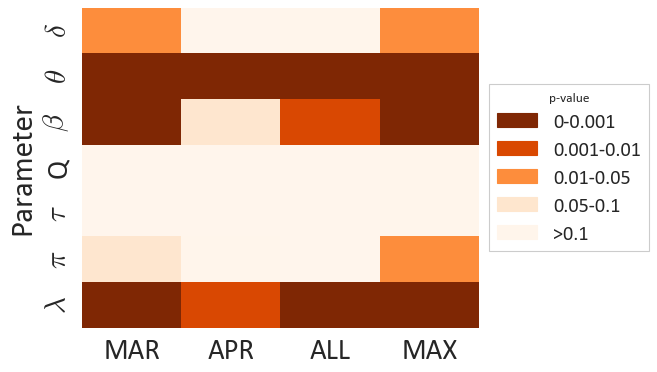

In [69]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
#['#f1eef6','#d7b5d8','#df65b0','#dd1c77','#980043']
#['#feedde','#fdd0a2','#fdae6b','#fd8d3c','#e6550d','#a63603']
colors = [[0, '#7f2704'],
          [0.0009999999,'#7f2705'],
          [0.001, '#d94801'],
          [0.0099999999, '#d94802'],
          [0.01, '#fd8d3c'],
          [0.0499999999, '#fd8d3d'],
          [0.05, '#fee6ce'],
          [0.0999999999, '#fee6cf'],
          [0.1, '#fff5eb'],
         [1, '#fff5ec']]

#colors = []

all_colors = ['#fff5eb','#fee6ce','#fd8d3c','#d94801','#7f2704']
all_colors.reverse()
diff_ranges = [(0, 0.001), (0.001, 0.01), (0.01, 0.05), (0.05, 0.1), (0.1,1)]

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# colors.append('#a63603')
# cur_list = rearranged_df.values.flatten().tolist()
# cur_list.sort()
# for val in cur_list:
#     colors.append([val,diff_to_color(val)])
# colors.append([1.0,'#ffffff'])
#colors.sort()

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'>{diff_range[0]}')
    #elif i==0:
    #    legend_labels.append(f'<{diff_range[1]}%')
    else:
        legend_labels.append(f'{diff_range[0]}-{diff_range[1]}')


cmap = LinearSegmentedColormap.from_list('', colors)

print(cmap)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

#fig,ax = plt.subplots(figsize=(8,5))

fig,ax = plt.subplots(figsize=(8,5))
sns.heatmap(rearranged_df, cmap=cmap,ax=ax,cbar=False)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(handles=legend_handles,labels=legend_labels,title='p-value',fontsize=18,loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
ax.set_ylabel('Parameter')
fig.savefig('../Figures/global_sensitivity_analysis.png',dpi=350,bbox_inches='tight')

In [108]:
colors

[[6.81443888e-12, '#a63603'],
 [3.77689061861e-09, '#a63603'],
 [4.87197365354e-09, '#a63603'],
 [6.09580736191e-09, '#a63603'],
 [1.2687563386609e-07, '#a63603'],
 [2.07772010907489e-06, '#a63603'],
 [4.41311343681051e-06, '#a63603'],
 [3.555259875896048e-05, '#a63603'],
 [8.919284850319206e-05, '#a63603'],
 [0.003876482937491727, '#e6550d'],
 [0.008142930871768423, '#e6550d'],
 [0.02017667242652628, '#fd8d3c'],
 [0.02764613822865664, '#fd8d3c'],
 [0.043079494343374734, '#fd8d3c'],
 [0.046359107126803877, '#fd8d3c'],
 [0.08958350824736883, '#fd8d3c'],
 [0.11322645503800916, '#fdbe85'],
 [0.17257210660925087, '#fdbe85'],
 [0.18730758291724783, '#fdbe85'],
 [0.19069075353622045, '#fdbe85'],
 [0.26977621559890885, '#fdbe85'],
 [0.5807032696381862, '#ffffff'],
 [0.6087667596334201, '#ffffff'],
 [0.6251714435525234, '#ffffff'],
 [0.7735801615211507, '#ffffff'],
 [0.7748014225111725, '#ffffff'],
 [0.8194325952399338, '#ffffff'],
 [0.8533300194183798, '#ffffff'],
 [0.9136383153943302, '#ffff

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Sample 2D NumPy array
data = np.random.randint(1, 101, size=(10, 10))  # Replace this with your own data

# Define custom color thresholds and corresponding colors
color_thresholds = [25, 50, 75, 100]
colors = ['blue', 'green', 'green', 'red']

# Create a custom colormap with repeated colors for specific ranges
cmap = ListedColormap(np.repeat(colors, np.diff(color_thresholds), axis=0))

# Create a mask for values outside the defined range
mask = np.zeros_like(data, dtype=bool)
for threshold in color_thresholds:
    mask |= (data > threshold)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt='d', cmap=cmap, mask=mask, cbar=False, square=True)

# Customize the colorbar
colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ticks=[0.5, 1.5, 3.5, 5.5], aspect=10)
colorbar.set_ticklabels(['<25', '25-50', '50-75', '75-100'])

# Set axis labels and title
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Custom Heatmap with Defined Color Ranges')

# Show the plot
plt.show()


ValueError: operands could not be broadcast together with shape (4,) (3,)

In [76]:
pearson_by_

['output_APR', 'output_MAR', 'output_MAX', 'output_tot']

In [79]:
df = pearson_by_output_type[3]
df = df.style.applymap(lambda x: "background-color: #fb9a99" if x<0.05 else "background-color: white",subset=[df.columns.tolist()[-1]])
df

,Param,PRCC for output_MAX,CI95% for output_MAX,p-value for output_MAX
27,$\delta$,-0.237542,[-0.42 -0.03],0.022607
28,Q,0.107226,[-0.1 0.31],0.308988
29,$\tau$,-0.140070,[-0.34 0.07],0.182955
30,$\theta$,0.565224,[0.41 0.69],0.000000
31,$\beta$,0.545113,[0.38 0.67],0.000000
32,$\pi^{\downarrow}$,-0.137616,[-0.33 0.07],0.190823
33,$\pi^{\uparrow}$,-0.241295,[-0.43 -0.04],0.020497
34,$\lambda$,-0.414419,[-0.57 -0.23],0.000040
35,Hop,0.073743,[-0.13 0.27],0.484805


In [101]:
pg.partial_corr(data=df, x='x', y='y', covar='cv1').round(2)

,n,r,CI95%,p-val
pearson,30,0.57,"[0.25, 0.77]",0.0


In [107]:
pg.partial_corr(data=df, x='x', y='y', covar=['y','cv2','cv3']).round(10)

,n,r,CI95%,p-val
pearson,30,-0.094767,"[-0.46, 0.3]",0.638226


In [156]:
sum(all_mses)/len(all_mses)

26000.035190333296

In [157]:
np.std(all_mses)

1301.9169308224493

In [ ]:
(compare_df['median']-compare_df['refugee'])

In [61]:
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum()
compare_df['q1'].sum()
compare_df['q3'].sum()

3400824.6428571427

In [45]:
compare_df

NameError: name 'compare_df' is not defined

## get raion/oblast/macro-region level estimate

In [46]:
def get_raion_total(raion,end_date,hyper_comb,prefix='fresh_calib_batch_simulation'):
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name
    else:
        return 0
    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    cur_df = cur_df[cur_df.time<=pd.to_datetime(end_date)]
    return cur_df['refugee'].sum()


len(burundi_gdf['ADM1_EN'].unique().tolist())

27

In [47]:
burundi_gdf['ADM1_EN'].unique()

array(['Autonomous Republic of Crimea', 'Vinnytska', 'Volynska',
       'Dnipropetrovska', 'Donetska', 'Zhytomyrska', 'Zakarpatska',
       'Zaporizka', 'Ivano-Frankivska', 'Kyivska', 'Kirovohradska',
       'Luhanska', 'Lvivska', 'Mykolaivska', 'Odeska', 'Poltavska',
       'Rivnenska', 'Sumska', 'Ternopilska', 'Kharkivska', 'Khersonska',
       'Khmelnytska', 'Cherkaska', 'Chernivetska', 'Chernihivska', 'Kyiv',
       'Sevastopol'], dtype=object)

In [48]:
gen_for = 'Macro-region'

In [53]:
idp_macro_map = pd.read_csv('idp_macro.csv')
idp_macro_map = idp_macro_map[idp_macro_map['Macro-region']!='Crimea']
burundi_macro = burundi_gdf[['ADM2_EN','ADM1_EN','geometry']].merge(idp_macro_map,left_on='ADM1_EN',right_on='Oblast',how='inner')
raion_displace = pd.DataFrame(columns=['ADM2_EN','displacement'])
hyper_comb = 20089
until = '2022-03-16'
for r in burundi_macro.ADM2_EN.unique().tolist():
    raion_displace = raion_displace.append({'ADM2_EN':r,'displacement':get_raion_total(r,until,hyper_comb,prefix='mim_result')*1.2*(0.7/0.3)},ignore_index=True)

burundi_macro_displace = burundi_macro.merge(raion_displace,on='ADM2_EN',how='inner')

macro_df = burundi_macro_displace.groupby(gen_for)['displacement'].sum().reset_index()

In [54]:
macro_df['displacement_percentage_abm'] = ((macro_df['displacement']/macro_df['displacement'].sum() )*100.0).astype(float).round(1)
macro_df = macro_df.drop(columns=['displacement'])
macro_df

,Macro-region,displacement_percentage_abm
0,Center,3.7
1,East,38.1
2,Kyiv,25.7
3,North,19.2
4,South,9.6
5,West,3.8


In [55]:
def get_raion_total_sofa(raion,end_date,hyper_comb,prefix='fresh_calib_batch_simulation'):
    OUTPUT_DIR_OLD = BASE_DIR+'output_data/' 
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    if os.path.isfile(OUTPUT_DIR_OLD+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR_OLD+f2_name):
        true_f_name = f2_name
    else:
        return 0
    cur_df = pd.read_csv(OUTPUT_DIR_OLD+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    BORDER_CROSS_PROB = float(np.random.normal(0.32,0.02,1)[0])
    IDP_PROB = 1.0 - BORDER_CROSS_PROB
    #IDP_REFUGEE_PROB = 0.1
    cur_df['FD'] = cur_df['refugee']/BORDER_CROSS_PROB
    cur_df['IDP'] = cur_df['FD']*IDP_PROB
    cur_df = cur_df[cur_df.time<=pd.to_datetime(end_date)]
    return cur_df['IDP'].sum()
    
raion_displace_sofa = pd.DataFrame(columns=['ADM2_EN','displacement'])
hyper_comb = 80009
until = '2022-03-16'
for r in burundi_macro.ADM2_EN.unique().tolist():
    raion_displace_sofa = raion_displace_sofa.append({'ADM2_EN':r,'displacement':get_raion_total_sofa(r,until,hyper_comb,prefix='mim_result')*1.2*(0.7/0.3)},ignore_index=True)

burundi_macro_displace_sofa = burundi_macro.merge(raion_displace_sofa,on='ADM2_EN',how='inner')

macro_df_sofa = burundi_macro_displace_sofa.groupby(gen_for)['displacement'].sum().reset_index()
macro_df_sofa['displacement_percentage_pandey'] =(( macro_df_sofa['displacement']/macro_df_sofa['displacement'].sum() )*100.0).astype(float).round(1)
macro_df_sofa = macro_df_sofa.drop(columns=['displacement'])
macro_df_sofa

,Macro-region,displacement_percentage_pandey
0,Center,5.1
1,East,47.8
2,Kyiv,12.8
3,North,18.4
4,South,10.9
5,West,5.1


In [58]:
macro_df_observe = pd.read_csv('idp_observe_percent_macro.csv')
macro_df_observe

,Macro-region,IDP%
0,Kyiv,29.9
1,East,36.2
2,South,7.5
3,Center,3.4
4,North,20.1
5,West,2.9


In [59]:
macro_compare = (macro_df.merge(macro_df_observe,on='Macro-region',how='inner')).merge(macro_df_sofa,on='Macro-region',how='inner')
macro_compare

,Macro-region,displacement_percentage_abm,IDP%,displacement_percentage_pandey
0,Center,3.7,3.4,5.1
1,East,38.1,36.2,47.8
2,Kyiv,25.7,29.9,12.8
3,North,19.2,20.1,18.4
4,South,9.6,7.5,10.9
5,West,3.8,2.9,5.1


In [60]:
macro_compare.to_csv('aamas_idp_macro_compare.csv',index=False)

In [61]:
burundi_macro_gdf = burundi_macro.dissolve(by=gen_for)
burundi_macro_gdf = burundi_macro_gdf[['geometry']].reset_index()
ukr_idp_macro_info_df =  burundi_macro_gdf.merge(macro_compare,on=gen_for,how='inner')
ukr_idp_macro_info_df

,Macro-region,geometry,displacement_percentage_abm,IDP%,displacement_percentage_pandey
0,Center,"POLYGON ((33.89376 48.90201, 33.89338 48.90023...",3.7,3.4,5.1
1,East,"MULTIPOLYGON (((36.80474 46.70357, 36.80450 46...",38.1,36.2,47.8
2,Kyiv,"POLYGON ((30.73374 50.58799, 30.75192 50.58356...",25.7,29.9,12.8
3,North,"MULTIPOLYGON (((35.43876 50.54346, 35.43893 50...",19.2,20.1,18.4
4,South,"MULTIPOLYGON (((30.20662 45.25740, 30.20674 45...",9.6,7.5,10.9
5,West,"POLYGON ((27.37291 48.63015, 27.37866 48.62870...",3.8,2.9,5.1


In [62]:
ukr_idp_macro_info_df.sort_values(by='displacement_percentage_abm',ascending=False).head(20)

,Macro-region,geometry,displacement_percentage_abm,IDP%,displacement_percentage_pandey
1,East,"MULTIPOLYGON (((36.80474 46.70357, 36.80450 46...",38.1,36.2,47.8
2,Kyiv,"POLYGON ((30.73374 50.58799, 30.75192 50.58356...",25.7,29.9,12.8
3,North,"MULTIPOLYGON (((35.43876 50.54346, 35.43893 50...",19.2,20.1,18.4
4,South,"MULTIPOLYGON (((30.20662 45.25740, 30.20674 45...",9.6,7.5,10.9
5,West,"POLYGON ((27.37291 48.63015, 27.37866 48.62870...",3.8,2.9,5.1
0,Center,"POLYGON ((33.89376 48.90201, 33.89338 48.90023...",3.7,3.4,5.1


## draw map

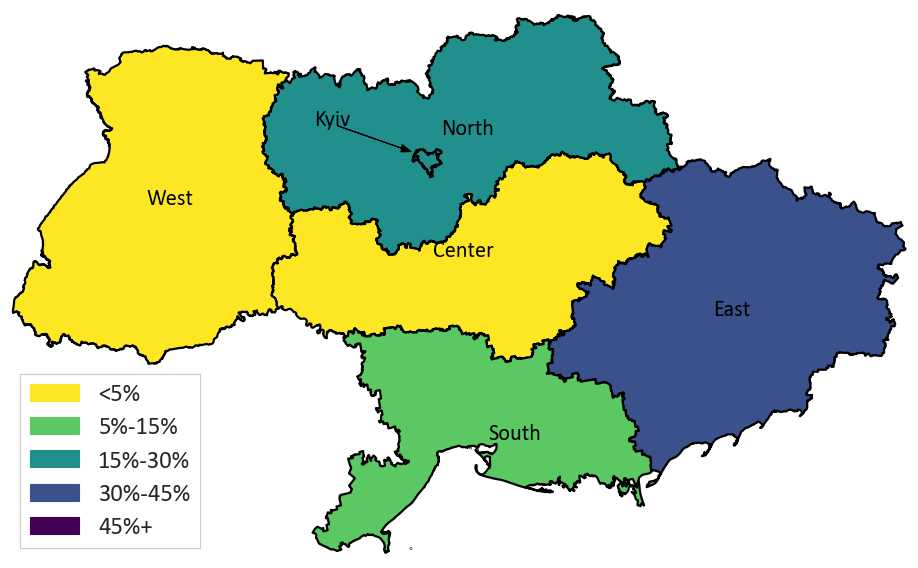

In [66]:
import matplotlib.pyplot as plt

# Set the column to use for the choropleth
all_colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']
diff_ranges = [(0, 5), (5, 15), (15, 30), (30, 45),(45,100)]
### 0,17112,43169,74445,118438,198192 previously

def diff_to_color(diff):
    if diff<0:
        return all_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return all_colors[i]
    return all_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, all_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]}%+')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]}%')
    else:
        legend_labels.append(f'{diff_range[0]}%-{diff_range[1]}%')

focus_column = 'IDP%'
ukr_idp_macro_info_df['diff_color'] = ukr_idp_macro_info_df[focus_column].apply(lambda x: diff_to_color(x))
# Create the figure and axis objects
fig,ax = plt.subplots(figsize=(12,8))
#plt.xticks(rotation=30)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
rcParams["axes.labelsize"] = 20
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

# Plot the polygons with the choropleth
#polygons_gdf.plot(column=value_column, cmap=cmap, ax=ax, edgecolor='black',scheme='EqualInterval',legend=True,legend_kwds={'fontsize':20,'loc':'lower left'})
ukr_idp_macro_info_df.plot(ax=ax,edgecolor='black',color=ukr_idp_macro_info_df['diff_color'],linewidth=2)

ukr_idp_macro_info_df['coords'] = ukr_idp_macro_info_df['geometry'].apply(lambda x: x.representative_point().coords[:])
ukr_idp_macro_info_df['coords'] = [coords[0] for coords in ukr_idp_macro_info_df['coords']]
for idx, row in ukr_idp_macro_info_df.iterrows():
    cur_coord = row['coords']
    if row['Macro-region']=='Kyiv':
        dx = -2
        dy = 0.5
        as_list = list(cur_coord)
        as_list[0] = as_list[0] + dx
        as_list[1] = as_list[1] + dy
        ax.arrow(as_list[0]+0.1,as_list[1],-dx-0.7,-dy+0.2,color='black',head_width = 0.1, head_length = 0.2)
        cur_coord = tuple(as_list)
    ax.annotate(s=row['Macro-region'], xy=cur_coord,ha='center',fontsize=20,color='#000000')

# Add a legend
EPS = 0.1
ax.set_xlim(ukr_idp_macro_info_df.total_bounds[0]-EPS, ukr_idp_macro_info_df.total_bounds[2]+EPS)
ax.set_ylim(ukr_idp_macro_info_df.total_bounds[1]-EPS, ukr_idp_macro_info_df.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower left',fontsize=22)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True,right=True,top=True,bottom=True)

fig.tight_layout()
fig.savefig('../Figures/aamas_'+focus_column+'_map.png',dpi=350,bbox_inches='tight')

## compare_everything

In [75]:
x = 7275283.098597599
y = 5523150.002945037
z = 1616600.5681473766
a = 10305552.99151849
b = 7887347.678246012
c = 2202283.6001177765

In [77]:
print(errmin)
print(errmax)

[[0, 0, 0], [927154, 522659, 358721], [1244574.9014024008, 961127.9970549634, 264553.43185262335]]
[[0, 0, 0], [1220107, 722269, 445122], [1785694.99151849, 1403069.678246012, 321129.60011777654]]


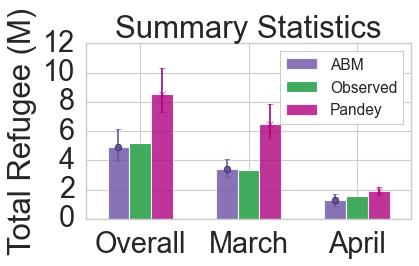

In [93]:
[errmin[1],errmax[1]]

[[927154, 522659, 358721], [1220107, 722269, 445122]]

In [81]:
np.array(abm_bar)/1e6

array([4.917812, 3.400824, 1.266664])

In [51]:
all_dfs = []
for region in all_ids:
    print(region,end=' ')
    try:
        cur_df = get_results_for_2(5000+101, who='refugee',region_name=[region],prefix='mim_result',partition = 20,scale_1 = 1.2,scale_2 = 1.5)
        cur_df['raion'] = region
        all_dfs.append(cur_df)
        #break
    except:
        print('chesta')
        continue

Bakhchysaraiskyi 1 raions found
Bilohirskyi 1 raions found
Dzhankoiskyi 1 raions found
Yevpatoriiskyi 1 raions found
Kerchynskyi 1 raions found
Krasnohvardiiskyi chesta
Krasnoperekopskyi chesta
Simferopolskyi 1 raions found
Feodosiiskyi 1 raions found
Yaltynskyi chesta
Vinnytskyi 1 raions found
Haisynskyi chesta
Zhmerynskyi 1 raions found
Mohyliv-Podilskyi chesta
Tulchynskyi chesta
Khmilnytskyi 1 raions found
Volodymyrskyi 1 raions found
Kamin-Kashyrskyi 1 raions found
Kovelskyi chesta
Lutskyi 1 raions found
Dniprovskyi 1 raions found
Kamianskyi 1 raions found
Kryvorizkyi 1 raions found
Nikopolskyi 1 raions found
Novomoskovskyi 1 raions found
Pavlohradskyi 1 raions found
Synelnykivskyi 1 raions found
Bakhmutskyi 1 raions found
Volnovaskyi 1 raions found
Horlivskyi 1 raions found
Donetskyi 1 raions found
Kalmiuskyi 1 raions found
Kramatorskyi 1 raions found
Mariupolskyi 1 raions found
Pokrovskyi 1 raions found
Berdychivskyi 1 raions found
Zhytomyrskyi 1 raions found
Korostenskyi 1 raion

In [53]:
pivot_df = pd.concat(all_dfs).pivot(index='raion',columns='time',values='refugee')
each_day_max_raion = pivot_df.idxmax().reset_index()

In [55]:
each_day_max_raion[0].value_counts()

Zaporizkyi      32
Kramatorskyi    12
Alchevskyi       8
Kyiv             8
Kryvorizkyi      8
Chuhuivskyi      7
Kharkivskyi      7
Mykolaivskyi     5
Khersonskyi      5
Donetskyi        2
Name: 0, dtype: int64

In [99]:
def assign_raion_to_dest(hyper_comb, raion, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 1.2,scale_2 = 1.5):
    all_dfs = []
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name

    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    all_dfs.append(cur_df)
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(ovr_df[who].sum(),end=' ')
    #dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_stock_only_'+str(raion)+'.csv')
    dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_stock_only_eu_only_'+str(raion)+'.csv')
    ovr_df['key'] = 1
    dest_df['key'] = 1
    raion_to_dest = ovr_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
    raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
    print(raion_to_dest['flow'].sum(),raion)
    raion_to_dest['from'] = raion
    return raion_to_dest

In [100]:
all_dests = []

for raion in all_ids:
    try:
        dest_raion_df = assign_raion_to_dest(5000+101,raion,prefix='mim_result')
        all_dests.append(dest_raion_df)
    except:
        continue

1337.485714285715 1337.485714285715 Bakhchysaraiskyi
26.4 26.4 Bilohirskyi
150.9 150.9 Dzhankoiskyi
165.59999999999997 165.59999999999997 Yevpatoriiskyi
277.5 277.5 Kerchynskyi
3431.0999999999995 3431.1 Simferopolskyi
120.0 120.0 Feodosiiskyi
16826.571428571435 16826.571428571428 Vinnytskyi
1351.5 1351.4999999999998 Zhmerynskyi
328.5 328.49999999999994 Khmilnytskyi
152.4 152.39999999999998 Volodymyrskyi
10.799999999999999 10.799999999999997 Kamin-Kashyrskyi
6888.3 6888.3 Lutskyi
63215.74285714286 63215.74285714286 Dniprovskyi
265.2 265.2 Kamianskyi
375983.9142857143 375983.91428571433 Kryvorizkyi
18583.842857142852 18583.842857142856 Nikopolskyi
477.0 477.0 Novomoskovskyi
3105.814285714286 3105.8142857142866 Pavlohradskyi
1775.0571428571427 1775.057142857143 Synelnykivskyi
68638.28571428574 68638.28571428575 Bakhmutskyi
72995.87142857142 72995.87142857145 Volnovaskyi
263723.3999999996 263723.3999999997 Horlivskyi
505756.41428571334 505756.41428571334 Donetskyi
63817.45714285707 63817.4

In [101]:
all_flow_from_all_raion = pd.concat(all_dests)
all_flow_from_all_raion.groupby('Country')['flow'].sum().reset_index().sort_values(by='flow',ascending=False)

,Country,flow
19,Poland,1.950578e+06
14,Italy,9.055663e+05
10,Germany,7.335411e+05
5,Czech Republic,5.643315e+05
12,Hungary,3.730222e+05
21,Romania,3.225132e+05
24,Spain,2.221435e+05
11,Greece,1.927058e+05
7,Estonia,1.826178e+05
2,Bulgaria,1.458914e+05


In [85]:
raion_df = get_results_for_2(5000+101,region_name=['Kyiv'],prefix='mim_result')
print(raion_df['refugee'].sum())
dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_'+str('Kyiv')+'.csv')
dest_df['rij'].sum()
raion_df['key'] = 1
dest_df['key'] = 1
raion_to_dest = raion_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
print(raion_to_dest['flow'].sum())

1 raions found
358943.28571428574
357090.9346861782
